In [2]:
import pandas as pd # type: ignore
import json
import re
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt

### Import the data and make it workable

In [3]:
# append_paths = [f'../data/raw/by_pages/page_{page_num}_apps.json' for page_num in range(0,3039)]
# apps = []
# for page_path in append_paths:
#     page = json.loads(open(page_path, 'r').read())
#     apps.extend(page)
# with open('workable_apps.json','w')as f:
#     json.dump(apps, f, indent=4)


In [4]:
with open('workable_apps.json','r')as f:
    apps = json.loads(f.read())


In [5]:
df = pd.DataFrame([app for app in apps if app])
df.shape

(17768, 33)

In [6]:
n_na = df.isna().sum(axis=0)
n_na.round(2)  # Percentage of missing values
df.shape

(17768, 33)

In [7]:
df.head(5)

,name,category,developer,release,setup_size,setup_type,compatibility,operating_system,ram_required,hdd_space,...,extra_10,extra_11,extra_12,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19
0,Valentina Studio Pro 2024,"Database, Development",Valentina Studio Pro,10th July 2024,118 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,1 GB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Paragon APFS for Windows 2024,Softwares,Paragon APFS for Windows,10th July 2024,36 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Master Packager Pro 2024,Installer Creation,Master Packager Pro,10th July 2024,66 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,500 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Topaz Gigapixel AI 2024,"Photo Editing, Photo Retouching",Topaz Gigapixel,10th July 2024,286 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,200 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Navicat Premium 2024,3D Designing,Navicat,10th July 2024,184 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['category'].str.find(',')

0         8
1        -1
2        -1
3        13
4        -1
         ..
17763    -1
17764    -1
17765    -1
17766    -1
17767    -1
Name: category, Length: 17768, dtype: int64

### We can clean the columns with units example: hdd_space, ram, setup size, and also cpu

#### These are some cleaning functions

In [9]:
import datetime as dt

def parse_memory(x: str):
   try:
      # Extract the number part from the string
      number = re.search(r'\d+(\.\d+)?', x).group()
      number = float(number)  # Convert the extracted number to a float
   except (AttributeError, ValueError, TypeError):
      return np.nan  # Return NaN if no valid number is found

   # Determine the unit and convert accordingly
   if re.search(r'(MB|mb)', x):
      return number
   elif re.search(r'(KB|kb)', x):
      return number / 1000
   elif re.search(r'(GB|gb)', x):
      return number * 1000
   return np.nan 

def parse_compatibility(x: str):
   try:
      matches =  re.findall(r'(32|64|86)', x)
   except TypeError:
      return np.nan
   if matches:
      if '86' in matches:
         matches.remove('86')
         matches.insert(0, '32')
      matches = list(set(matches))
      matches = [int(num) for num in matches]
      return min(matches)
   else:
      return np.nan
   
def parse_date(date_str):
   try:
      # Remove the ordinal suffix (st, nd, rd, th)
      date_str = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)
      # Convert to datetime
      return pd.to_datetime(date_str, format='%d %B %Y')
   except Exception as e:
        np.nan
    
def categorize_os(value):
   try:  
      if re.search(r"7/8/8\.1/10", value):
         return "Modern Versions"
      elif re.search(r"7/8/10", value):
         return "Modern Versions"
      elif re.search(r"(2000/)?XP/Vista/7/8(/8\.1)?/10", value):
         return "All Windows versions"
      elif re.search(r"XP/Vista/7", value):
         return "Older Windows versions"
      else:
         return "Other"
   except TypeError:
      return np.nan


In [10]:
newdf = df.copy()

In [11]:
# parse_date(newdf.release[0])
newdf['release'] = newdf['release'].map(parse_date)
newdf['setup_size_MB'] = newdf['setup_size'].map(parse_memory)
newdf['hdd_space_MB'] = newdf['hdd_space'].map(parse_memory)
newdf['ram_required_MB'] = newdf['ram_required'].map(parse_memory)
newdf['minimum_os_bits']  = newdf['compatibility'].map(parse_compatibility)
newdf['os_version'] = newdf['operating_system'].map(categorize_os)
newdf = newdf.drop(['setup_size', 'setup_type','compatibility', 'operating_system', 'ram_required', 'hdd_space'], axis=1)

In [12]:
for col in list(newdf.columns):
    if col.startswith('extra'):
        newdf = newdf.drop(col, axis=1)

newdf.drop('release', axis=1, inplace=True)

In [13]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17768 entries, 0 to 17767
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             17768 non-null  object 
 1   category         17768 non-null  object 
 2   developer        16379 non-null  object 
 3   cpu              17628 non-null  object 
 4   img_link         17752 non-null  object 
 5   desc             17768 non-null  object 
 6   features         17768 non-null  object 
 7   setup_size_MB    17175 non-null  float64
 8   hdd_space_MB     16832 non-null  float64
 9   ram_required_MB  16498 non-null  float64
 10  minimum_os_bits  16970 non-null  float64
 11  os_version       17628 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.6+ MB


In [14]:
newdf['category'] = newdf['category'].astype("category")
newdf['os_version'] = newdf['os_version'].astype("category")
newdf['developer'] = newdf['developer'].astype("category")

In [15]:
newdf.dropna(inplace=True)

In [16]:
newdf = newdf.dropna().reset_index(drop=True)

In [17]:
newdf.shape

(15121, 12)

Text(0.5, 0, 'App count')

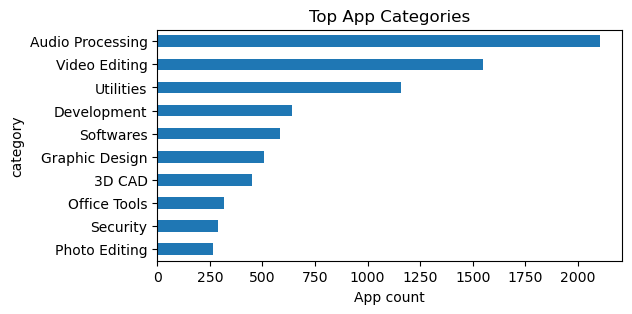

In [18]:
import seaborn as sns
plt.figure(figsize=(6,3))
ax = newdf.category.value_counts().nlargest(10).sort_values(ascending=True).plot.barh()
ax.set_title("Top App Categories")
ax.set_xlabel("App count")

In [19]:
def filter_dev(dev):
    if len((dev.split())) > 4:
        return np.nan
    else:
        return dev

In [20]:
newdf['developer'] = newdf['developer'].map(filter_dev)
# newdf['developer']#.map(lambda x: len((x.split())) < 3)

In [21]:
newdf.dropna(inplace=True)

In [22]:
newdf.shape

(15060, 12)

In [23]:
newdf.shape

(15060, 12)

In [35]:
nlp_df = newdf[["name","developer","category", "desc", "features", "img_link"]]

In [36]:
nlp_df = nlp_df.drop((nlp_df[nlp_df['developer'] == 'Free'].index.values))

<Axes: ylabel='developer'>

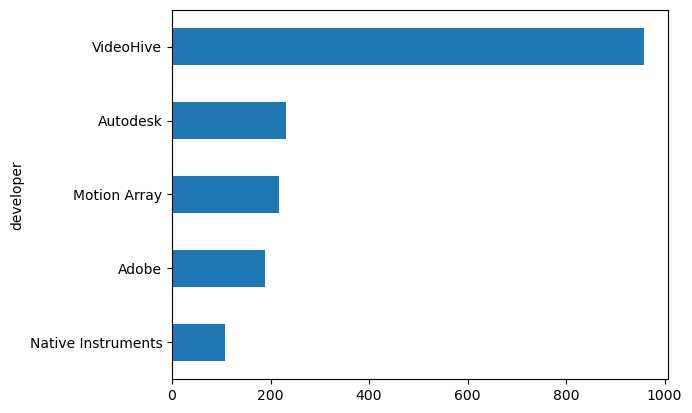

In [37]:

nlp_df['developer'].value_counts().nlargest(5).sort_values(ascending=True).plot.barh()

In [38]:
nlp_df['category'] = nlp_df.category.map(lambda x:x.split(",")[0])

<Axes: ylabel='category'>

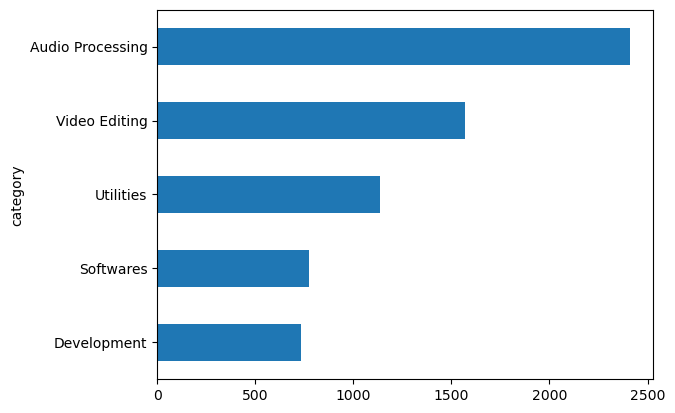

In [39]:
nlp_df['category'].value_counts().nlargest(5).sort_values(ascending=True).plot.barh()

In [40]:
nlp_df['category'].nunique()

160

In [44]:
nlp_df['tags'] = nlp_df['desc'] + nlp_df['features']

In [49]:
nlp_df.desc[0]

'Valentina Studio Pro 2024 is an award-winning application for modelling, reporting, editing, and managing the database. It provides a wide range of compression tools, diagnose capabilities, cloning functions, reindexing and defragment tools enabling users to create, alter, and browse various database elements, including tables, fields, indexes, and triggers. It enables database developers to easily run queries, administer and explore a wide range of popular databases such as MySQL, Valentina DB, PostgreSQL, MariaDB and SQLite. The GUI is neat and clean offering smooth navigation between the various database editing functions. It also supports simultaneous handling for multiple objects in multiple databases. You can also download Database Workbench Pro Free Download. Valentina Studio Pro 2024 is the ultimate suite which offers a perfect solution for comprehensive database development and management throughout the entire lifecycle. It enables database developers to create and modify all

In [48]:
nlp_df

,name,developer,category,desc,features,img_link,tags
0,Valentina Studio Pro 2024,Valentina Studio Pro,Database,Valentina Studio Pro 2024 is an award-winning ...,"Award-winning application for modelling, repor...",https://media.getintopc.com/2024/06/Valentina-...,Valentina Studio Pro 2024 is an award-winning ...
1,Paragon APFS for Windows 2024,Paragon APFS for Windows,Softwares,Paragon APFS for Windows 2024 is a professiona...,"Allows you to browse, read and write files on ...",https://media.getintopc.com/2024/06/Paragon-AP...,Paragon APFS for Windows 2024 is a professiona...
2,Master Packager Pro 2024,Master Packager Pro,Installer Creation,Master Packager Pro 2024 is a professional app...,Allows developers to easily create and edit Mi...,https://media.getintopc.com/2024/06/Master-Pac...,Master Packager Pro 2024 is a professional app...
3,Topaz Gigapixel AI 2024,Topaz Gigapixel,Photo Editing,Topaz Gigapixel AI 2024 is a professional phot...,Allows you to easily increase the resolution o...,https://media.getintopc.com/2024/07/Topaz-Giga...,Topaz Gigapixel AI 2024 is a professional phot...
4,Navicat Premium 2024,Navicat,3D Designing,Navicat Premium 2024 is a powerful and effecti...,Allows you to easily and quickly connect to a ...,https://media.getintopc.com/2024/06/Navicat-Pr...,Navicat Premium 2024 is a powerful and effecti...
...,...,...,...,...,...,...,...
15116,Typing Master,Typing Master Inc,Softwares,Typing Master is a typing assistance applicati...,Easy to use. One of the most efficient typing ...,https://media.getintopc.com/2013/02/Typing-Mas...,Typing Master is a typing assistance applicati...
15117,Uniblue DriverScanner,Uniblue Systems,Utilities,Drivers are necessary for establishing a conne...,Simple and straightforward interface. Updates ...,https://media.getintopc.com/2013/02/138376-140...,Drivers are necessary for establishing a conne...
15118,ESET NOD32,ESET,Antivirus,ESET NOD32 is a popular antivirus which provid...,"Provides protection against viruses, Trojans, ...",https://media.getintopc.com/2013/02/ESET-NOD32...,ESET NOD32 is a popular antivirus which provid...
15119,TeamViewer 8,TeamViewer Inc,Utilities,TeamViewer 8 is an application which will let ...,Can control distant computers remotely via int...,https://media.getintopc.com/2013/02/TeamViewer...,TeamViewer 8 is an application which will let ...
